## **Task 2**
## Loading the CIFAR-10

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np

# Load the CIFAR10 dataset
(x_train_full, _), (x_test_full, _) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values between 0 and 1
x_train_full = x_train_full.astype('float32') / 255
x_test_full = x_test_full.astype('float32') / 255


## Creating the desired dataset from the original CIFAR-10
To generate the target dataset from the original CIFAR-10, I chose 2000 images from the train set and 800 images from the test set, resulting in 1000 and 400 pairs of images for the model's output for trainset and test set respectively. The input for the model was created by averaging these pairs of images.






In [52]:
def create_pairs_and_averages(images):
    np.random.shuffle(images)
    pairs = np.reshape(images, (images.shape[0] // 2, 2, 32, 32, 3))
    averages = np.mean(pairs, axis=1)
    return pairs, averages

# Create pairs and averages for both training and test sets
train_pairs, train_averages = create_pairs_and_averages(x_train_full[:2000])
test_pairs, test_averages = create_pairs_and_averages(x_test_full[:800])


## Here, I've crafted an AutoEncoder model with just two layers.






In [57]:
from tensorflow.keras import layers, models
import tensorflow as tf

def autoencoder_model():
    input_img = layers.Input(shape=(32, 32, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder


##  Here, I implemented a parallel Autoencoder to ensure that the model is trained independently for each desired output.


In [58]:
class ParallelAutoencoder(tf.keras.Model):
    def __init__(self):
        super(ParallelAutoencoder, self).__init__()
        self.autoencoder1 = autoencoder_model()
        self.autoencoder2 = autoencoder_model()

    def call(self, x):
        out1 = self.autoencoder1(x)
        out2 = self.autoencoder2(x)
        return out1, out2


## Initializing the ParallelAutoencoder and optimizers


In [59]:
parallel_model = ParallelAutoencoder()
optimizer1 = tf.keras.optimizers.Adam()
optimizer2 = tf.keras.optimizers.Adam()

## Defining the train_step and test_step and utilizing the SSIM loss here

In [60]:
@tf.function
def train_step(x, y1, y2):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        out1, out2 = parallel_model(x)
        loss1 = 1 - tf.reduce_mean(tf.image.ssim(y1, out1, max_val=1.0))  # SSIM returns a value between -1 and 1. We want a loss that is 0 for perfect similarity, hence 1 - SSIM
        loss2 = 1 - tf.reduce_mean(tf.image.ssim(y2, out2, max_val=1.0))
    gradients1 = tape1.gradient(loss1, parallel_model.autoencoder1.trainable_variables)
    gradients2 = tape2.gradient(loss2, parallel_model.autoencoder2.trainable_variables)
    optimizer1.apply_gradients(zip(gradients1, parallel_model.autoencoder1.trainable_variables))
    optimizer2.apply_gradients(zip(gradients2, parallel_model.autoencoder2.trainable_variables))
    return loss1, loss2

@tf.function
def test_step(x, y1, y2):
    out1, out2 = parallel_model(x)
    loss1 = 1 - tf.reduce_mean(tf.image.ssim(y1, out1, max_val=1.0))
    loss2 = 1 - tf.reduce_mean(tf.image.ssim(y2, out2, max_val=1.0))
    return loss1, loss2
# Preparing the dataset for training and testing...
train_dataset = tf.data.Dataset.from_tensor_slices((train_averages, train_pairs[:, 0], train_pairs[:, 1])).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_averages, test_pairs[:, 0], test_pairs[:, 1])).batch(32)


## Training and Evaluating the model, also plotting the loss curves


Epoch 1, Train Loss1: 0.725685179233551, Train Loss2: 0.7147729396820068, Test Loss1: 0.6598333120346069, Test Loss2: 0.6496428847312927
Epoch 2, Train Loss1: 0.6132630109786987, Train Loss2: 0.6202138066291809, Test Loss1: 0.6082184910774231, Test Loss2: 0.6126537322998047
Epoch 3, Train Loss1: 0.5804517269134521, Train Loss2: 0.5894295573234558, Test Loss1: 0.5795255899429321, Test Loss2: 0.5830205678939819
Epoch 4, Train Loss1: 0.5604304671287537, Train Loss2: 0.5667095184326172, Test Loss1: 0.5536617636680603, Test Loss2: 0.5641813278198242
Epoch 5, Train Loss1: 0.5466200113296509, Train Loss2: 0.5532421469688416, Test Loss1: 0.5474777817726135, Test Loss2: 0.5610800385475159
Epoch 6, Train Loss1: 0.5387853384017944, Train Loss2: 0.5458842515945435, Test Loss1: 0.5419999361038208, Test Loss2: 0.5572571158409119
Epoch 7, Train Loss1: 0.532089114189148, Train Loss2: 0.5408691167831421, Test Loss1: 0.537790834903717, Test Loss2: 0.5516104698181152
Epoch 8, Train Loss1: 0.5264987349510

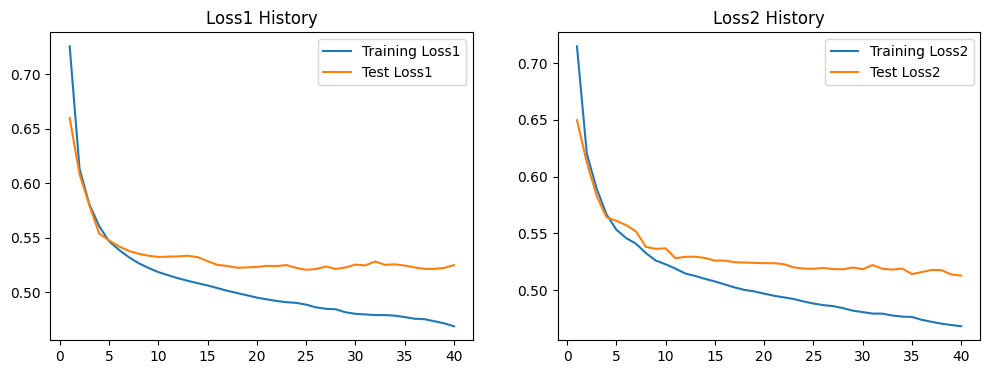

In [61]:
import matplotlib.pyplot as plt
num_epochs = 40
train_loss1_history = []
train_loss2_history = []
test_loss1_history = []
test_loss2_history = []

for epoch in range(num_epochs):
    epoch_train_loss1 = 0
    epoch_train_loss2 = 0
    epoch_test_loss1 = 0
    epoch_test_loss2 = 0
    train_steps = 0
    test_steps = 0
    for step, (x_batch_train, y_batch_train1, y_batch_train2) in enumerate(train_dataset):
        loss1, loss2 = train_step(x_batch_train, y_batch_train1, y_batch_train2)
        epoch_train_loss1 += loss1
        epoch_train_loss2 += loss2
        train_steps += 1
    for x_batch_test, y_batch_test1, y_batch_test2 in test_dataset:
        loss1, loss2 = test_step(x_batch_test, y_batch_test1, y_batch_test2)
        epoch_test_loss1 += loss1
        epoch_test_loss2 += loss2
        test_steps += 1
    train_loss1_history.append(epoch_train_loss1 / train_steps)
    train_loss2_history.append(epoch_train_loss2 / train_steps)
    test_loss1_history.append(epoch_test_loss1 / test_steps)
    test_loss2_history.append(epoch_test_loss2 / test_steps)
    print(f'Epoch {epoch + 1}, Train Loss1: {train_loss1_history[-1]}, Train Loss2: {train_loss2_history[-1]}, Test Loss1: {test_loss1_history[-1]}, Test Loss2: {test_loss2_history[-1]}')

# Plotting the losses
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), train_loss1_history, label='Training Loss1')
plt.plot(range(1, num_epochs + 1), test_loss1_history, label='Test Loss1')
plt.legend()
plt.title('Loss1 History')

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs + 1), train_loss2_history, label='Training Loss2')
plt.plot(range(1, num_epochs + 1), test_loss2_history, label='Test Loss2')
plt.legend()
plt.title('Loss2 History')

plt.show()

## Plot randomly the input, target and model outputs for 5 pairs

1/1 [==============================] - 0s 125ms/step


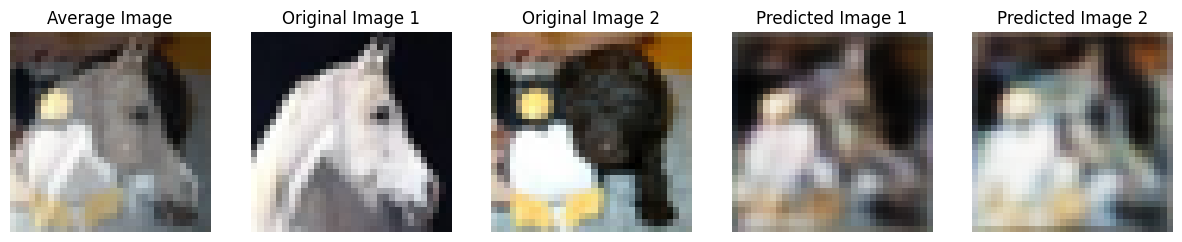

1/1 [==============================] - 0s 17ms/step


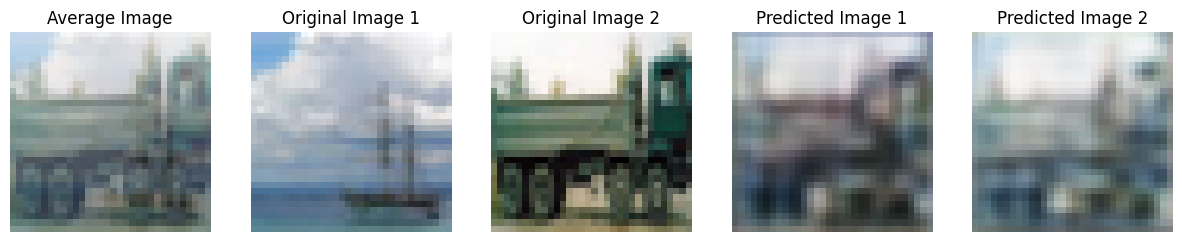

1/1 [==============================] - 0s 22ms/step


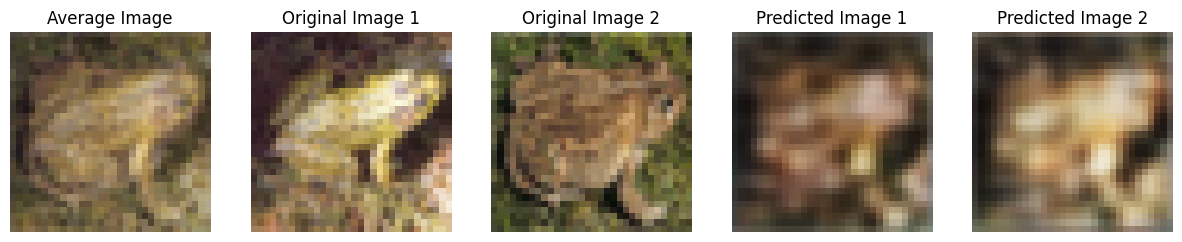

1/1 [==============================] - 0s 18ms/step


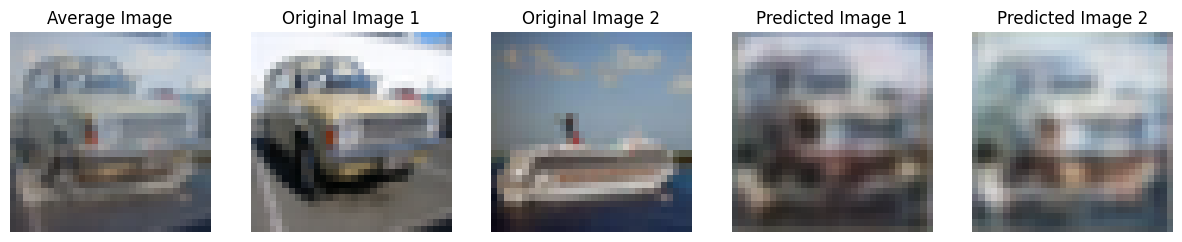

1/1 [==============================] - 0s 24ms/step


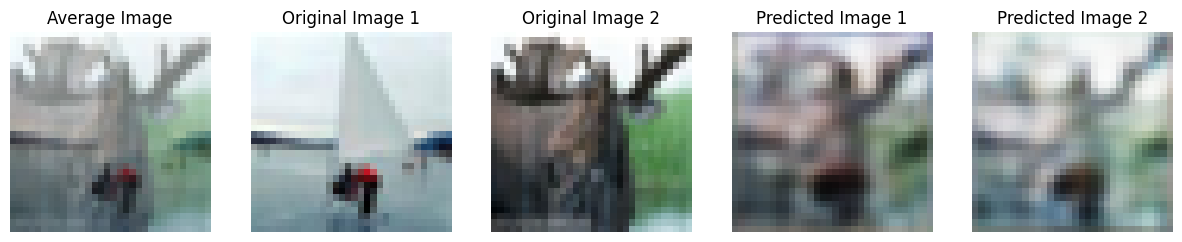

In [62]:

def plot_random_pairs(n, pairs, averages, model):
    indices = np.random.choice(len(pairs), size=n, replace=False)
    for index in indices:
        average_image = averages[index]
        original_images = pairs[index]
        predicted_images = model.predict(average_image[np.newaxis, ...])

        fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # dpi removed as it's not a valid argument for subplots

        titles = ['Average Image', 'Original Image 1', 'Original Image 2', 'Predicted Image 1', 'Predicted Image 2']
        for ax, img, title in zip(axes, [average_image] + list(original_images) + list(predicted_images[0]) + list(predicted_images[1]), titles):
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')

        plt.show()

# Call the function to plot random pairs after all epochs have been completed
plot_random_pairs(5, test_pairs, test_averages, parallel_model)
